In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation, LeakyReLU, Dense, Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import tensorflow_datasets as tfds
import pathlib
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import ssim
import tensorflow_addons as tfa



C:\Users\a\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\a\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're usin

In [2]:
#----------------------------------------------------------------------------------------------
#CHARGER ET TRANSFORMER LES DONNES

# Directory where the images are located
image_dir = r'D:\DATA_PROJET_ML1\landscape-pictures'

# Create a dataset of all image files in the directory
image_paths = pathlib.Path(image_dir).glob('*.jpg')
image_paths = [str(path) for path in image_paths]
image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)


In [3]:
# Function to load and preprocess each image, convert it to grayscale and normalize
def to_grayscale(image):
    return tf.image.rgb_to_grayscale(image)

def normalize(image):
    return tf.cast(image, tf.float32) / 255.0

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    return image

def count_elements(dataset):
    return len(list(dataset))

def convert_grayscale_to_rgb(image):
    return tf.concat([image, image, image], axis=-1)


In [4]:
# Load and preprocess the images
image_dataset = image_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

num_images = image_dataset.cardinality().numpy()
num_train_images = int(0.8 * num_images)
normalized_dataset = image_dataset.map(normalize)
train_dataset = normalized_dataset.take(num_train_images)
val_dataset = normalized_dataset.skip(num_train_images)

train_dataset_gray = train_dataset.map(to_grayscale)
val_dataset_gray = val_dataset.map(to_grayscale)

train_dataset_rgb = train_dataset_gray.map(convert_grayscale_to_rgb)
val_dataset_rgb = val_dataset_gray.map(convert_grayscale_to_rgb)

In [5]:
BATCH_SIZE = 16

# Shuffle the training data
SHUFFLE_BUFFER_SIZE = num_train_images  # or any other buffer size you find appropriate
train_data = tf.data.Dataset.zip((train_dataset_rgb, train_dataset))
train_data = train_data.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

# Re-batch and prefetch the training data
train_data = train_data.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

# Do not shuffle the validation data
val_data = tf.data.Dataset.zip((val_dataset_rgb, val_dataset))
val_data = val_data.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
#----------------------------------------------------------------------------------------------
#Importer le generateur et le discriminateur

def combined_loss(y_true, y_pred):
    # Calculate mean absolute error
    mae = MeanAbsoluteError()(y_true, y_pred)
    # Calculate SSIM loss as 1 - mean SSIM
    ssim_loss = 1 - tf.reduce_mean(ssim(y_true, y_pred, max_val=1.0))
    # Weight the losses and combine
    combined = (0.7 * ssim_loss) + (0.3 * mae)
    return combined

# #GENERATEUR U-NET
generator = tf.keras.models.load_model('unetMobileNetv2.h5', custom_objects={'combined_loss': combined_loss})

# Unfreeze all layers in the generator
for layer in generator.layers:
    layer.trainable = True
    initializer = tf.keras.initializers.HeNormal()

# Define the initializer
initializer = tf.keras.initializers.HeNormal()

# Discriminator with Spectral Normalization
inputs = Input(shape=[128, 128, 3])

# First Convolutional Block
conv1 = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer)
sn_conv1 = tfa.layers.SpectralNormalization(conv1)(inputs)
d = LeakyReLU(alpha=0.2)(sn_conv1)

# Second Convolutional Block
conv2 = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer)
sn_conv2 = tfa.layers.SpectralNormalization(conv2)(d)
d = LeakyReLU(alpha=0.2)(sn_conv2)

# Third Convolutional Block
conv3 = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer)
sn_conv3 = tfa.layers.SpectralNormalization(conv3)(d)
d = LeakyReLU(alpha=0.2)(sn_conv3)

# Fourth Convolutional Block
conv4 = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer)
sn_conv4 = tfa.layers.SpectralNormalization(conv4)(d)
d = LeakyReLU(alpha=0.2)(sn_conv4)

# Output Convolutional Layer
final_conv = Conv2D(1, (4, 4), padding='same', kernel_initializer=initializer)
d = final_conv(d)  # Output will be a patch

# Create Discriminator Model
discriminator = Model(inputs, d)


In [7]:
#-----------------------------------------------------------------------------------------------
##MODELE COMBINE
def wasserstein_loss(y_true, y_pred):
    return -tf.reduce_mean(y_true * y_pred)

def compute_l1_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def gradient_penalty(real_images, fake_images, discriminator):
    batch_size = tf.shape(real_images)[0]
    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)

    grads = gp_tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0004)
discriminator.compile(loss=wasserstein_loss, optimizer=discriminator_optimizer)

# For the combined model, set discriminator to non-trainable
discriminator.trainable = False

inputs = tf.keras.layers.Input(shape=[128, 128, 3])
colorized_image = generator(inputs)  # Generate images using the pre-trained U-Net
validity = discriminator(colorized_image)

combined = tf.keras.models.Model(inputs, validity)
combined_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001)
combined.compile(loss=wasserstein_loss, optimizer=combined_optimizer)

In [8]:
#-----------------------------------------------------------------------------------------------
##METRIQUE AVANT GAN

initial_ssim_scores = []
for gray_images_val, real_images_val in val_data:
    generated_images_val = generator.predict(gray_images_val)
    initial_ssim = ssim(real_images_val, generated_images_val, max_val=1.0)
    initial_ssim_scores.append(initial_ssim)

avg_initial_ssim = np.mean(initial_ssim_scores)
print(f"Initial Validation SSIM: {avg_initial_ssim:.4f}")

Initial Validation SSIM: 0.8993


Epoch 1/1
Epoch 1/1 - Processing Batch 100/215
Epoch 1/1 - Processing Batch 200/215
[D loss: 2.514209508895874] [G loss: 0.14992767572402954]
Validation SSIM for epoch 1: 0.8696
Validation L1 Loss for epoch 1: 0.0694


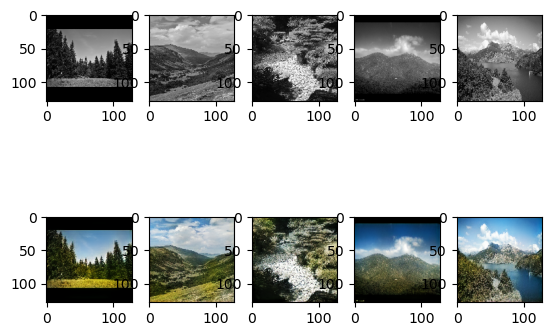

In [9]:
#-----------------------------------------------------------------------------------------------
##ENTRAINER LE GAN


def train_wgan(epochs, train_data, generator, discriminator, combined, gp_weight=10.0, combined_weight=1.0):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        d_losses = []
        g_losses = []

        total_batches = len(train_data)

        for batch_i, (gray_images, real_images) in enumerate(train_data):

            with tf.GradientTape() as disc_tape:
                generated_images = generator(gray_images, training=True)
                real_output = discriminator(real_images, training=True)
                fake_output = discriminator(generated_images, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = gradient_penalty(real_images, generated_images, discriminator)
                disc_loss += gp * gp_weight

            # Calculate discriminator gradients and update weights
            disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

            d_losses.append(disc_loss.numpy())

            # Train generator

            with tf.GradientTape() as gen_tape:
                generated_images = generator(gray_images, training=True)
                fake_output = discriminator(generated_images, training=True)
                gen_adv_loss = -tf.reduce_mean(fake_output)
                gen_combined_loss = combined_loss(real_images, generated_images)
                gen_total_loss = gen_adv_loss + combined_weight * gen_combined_loss

            gen_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
            combined_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))

            g_losses.append(gen_total_loss.numpy())

            # Print which batch is currently being processed
            if (batch_i + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{epochs} - Processing Batch {batch_i + 1}/{total_batches}")

        avg_d_loss = np.mean(d_losses, axis=0)
        avg_g_loss = np.mean(g_losses, axis=0)

        # Print the progress
        print(f"[D loss: {avg_d_loss}] [G loss: {avg_g_loss}]")

        # Initialize lists to store SSIM and L1 loss scores
        val_ssim_scores = []
        val_l1_losses = []

        for gray_images_val, real_images_val in val_data:
            generated_images_val = generator.predict(gray_images_val)

            # Calculate SSIM
            val_ssim = ssim(real_images_val, generated_images_val, max_val=1.0)
            val_ssim_scores.append(val_ssim)

            # Calculate L1 loss
            val_l1_loss = tf.reduce_mean(tf.abs(real_images_val - generated_images_val))
            val_l1_losses.append(val_l1_loss)

        # Calculate average SSIM and L1 loss for the validation set
        avg_val_ssim = np.mean(val_ssim_scores)
        avg_val_l1_loss = np.mean(val_l1_losses)

        # Print the validation metrics
        print(f"Validation SSIM for epoch {epoch + 1}: {avg_val_ssim:.4f}")
        print(f"Validation L1 Loss for epoch {epoch + 1}: {avg_val_l1_loss:.4f}")

        # Optionally save generated images or models at the end of some epochs to monitor progress
        if (epoch + 1) % 1 == 0:
            # Save the generator model
            generator.save(f"generator_epoch_MobileNet_{epoch + 1}.h5")
            # Save the combined model
            combined.save(f"combined_model_epoch_{epoch + 1}.h5")

            # Generate sample images for visual inspection
            sample_gray_images, _ = next(iter(val_data))
            generated_images = generator.predict(sample_gray_images)

            # Plot and save the generated images
            for i in range(5):  # save first 5 images as an example
                plt.subplot(2, 5, i + 1)
                plt.imshow(tf.squeeze(sample_gray_images[i]), cmap='gray')
                plt.subplot(2, 5, i + 6)
                plt.imshow(generated_images[i])
            plt.savefig(f"generated_samples_epoch_MobileNet_{epoch + 1}.png")
            plt.show()


epochs=1
train_wgan(epochs, train_data, generator, discriminator, combined)

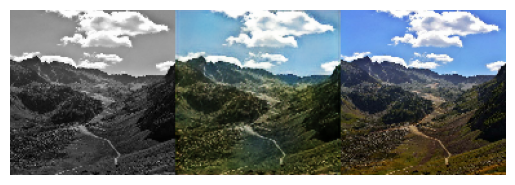

In [10]:
#----------------------

def duplicate_channels(image):
    return tf.repeat(image, repeats=3, axis=-1)

imgs_gray = val_dataset_gray.take(20)
imgs_color = val_dataset.take(20)

imgs_gray_3_channels = imgs_gray.map(duplicate_channels)

# Use the generator to colorize the images
imgs_colorized = generator.predict(imgs_gray_3_channels.batch(1))  # Add batch dimension for prediction

# Iterate over the images
for i, (img_gray, img_color, img_colorized) in enumerate(zip(imgs_gray, imgs_color, imgs_colorized)):
    # Rescale the pixel values from [0, 1] to [0, 255]
    img_gray = (img_gray.numpy() * 255).astype(np.uint8)
    img_color = (img_color.numpy() * 255).astype(np.uint8)
    img_colorized = ((imgs_colorized[i] * 255).astype(np.uint8))

    # Convert grayscale image to RGB
    img_gray_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)

    # Concatenate the grayscale, colorized and original RGB images
    img_combined = np.concatenate((img_gray_rgb, img_colorized, img_color), axis=1)

    # Save the combined image
    plt.imshow(img_combined)
    plt.axis('off')
    #plt.savefig(f'colorized_images/image_ResNet{i}_GAN.png')